In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:




y = snakemake_utils.get_dataset("polbook").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk/polbook/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['polbook_one/', 'polbook_two/', 'polbook_three/', 'polbook_four/', 'polbook_five/']
DATASET = 'polbook'
model_to_embs = {
    "GCN_baseline": '_gcn_None_deepwalk_deepwalk_embs.npy',
    "GCN_r2v": '_gcn_None_deepwalk_r2v_embs.npy',
    "GCN_baseline_fairwalk": "_gcn_fairwalk_deepwalk_deepwalk_embs.npy", 
    "GCN_r2v_fairwalk": "_gcn_fairwalk_deepwalk_r2v_embs.npy",
    "GAT_baseline": '_gat_None_deepwalk_deepwalk_embs.npy',
    "GAT_r2v": '_gat_None_deepwalk_r2v_embs.npy',
    "GAT_baseline_fairwalk": "_gat_fairwalk_deepwalk_deepwalk_embs.npy", 
    "GAT_r2v_fairwalk": "_gat_fairwalk_deepwalk_r2v_embs.npy",
    
    "word2vec_baseline": '_word2vec_None_deepwalk_deepwalk_embs.npy',
    "word2vec_r2v": '_word2vec_None_deepwalk_r2v_embs.npy',
    "word2vec_baseline_fairwalk": "_word2vec_fairwalk_deepwalk_deepwalk_embs.npy", 
    "word2vec_r2v_fairwalk": "_word2vec_fairwalk_deepwalk_r2v_embs.npy"
}
M = list(model_to_embs.keys())
TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk/polbook/polbook_one/polbook_test_adj.npz'
NUM_NODES=105
k=5

ls: cannot access '/data/sg/ashutiwa/final_results/airport/': No such file or directory


Using existing file polbooks.gml


# distributions of positive and negative edgeswith dot product

In [4]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [5]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [6]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# word2vec baseline

In [7]:
model = "word2vec_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


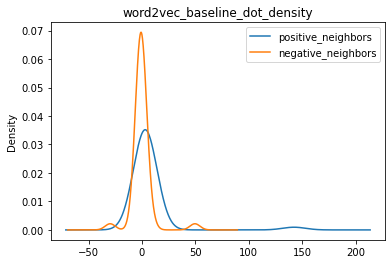

In [8]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2492.46it/s]


((525, 2), 0.03833148596780034, 0.873767258382643, 0.29057915845324783)

# word2vec fairwalk

In [10]:
model = "word2vec_baseline_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(105, 128)

selected edge_idx size: 39


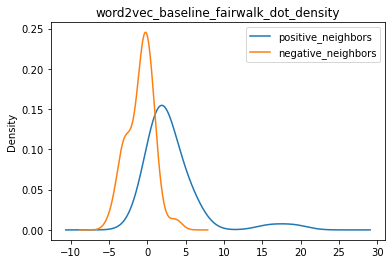

In [11]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [12]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4072.14it/s]


((525, 2), 0.04073907199241193, 0.9388560157790927, 0.2966451322695375)

# word2vec r2v

In [13]:
model = "word2vec_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


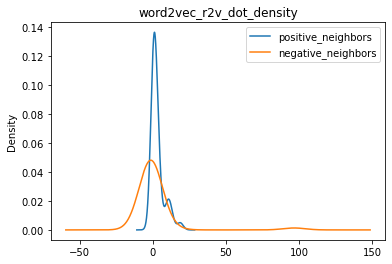

In [14]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [15]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3396.75it/s]


((525, 2), 0.027800486921634733, 0.9066403681788298, 0.21927353776091174)

# word2vec r2v fairwalk

In [16]:
model = "word2vec_r2v_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


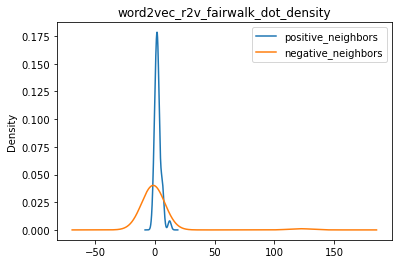

In [17]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [18]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3802.63it/s]


((525, 2), 0.03961970556269147, 0.915844838921762, 0.25536274944495074)

# GCN ( baseline)

In [19]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


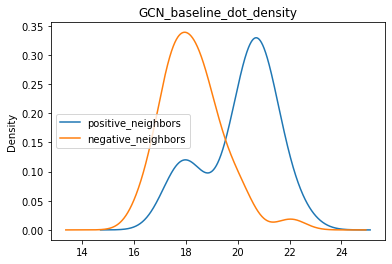

In [20]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [21]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3392.35it/s]


((525, 2), 0.06848729166655976, 0.8356344510190665, 0.42479922099296136)

# GCN ( baseline + fairwalk)

In [22]:
model = "GCN_baseline_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(105, 128)

selected edge_idx size: 39


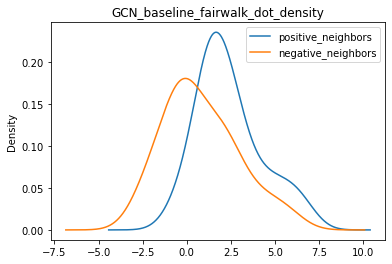

In [23]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [24]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3220.44it/s]


((525, 2), 0.06298851104668694, 0.7232084155161078, 0.4052288102562171)

# GCN ( r2v)

In [25]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


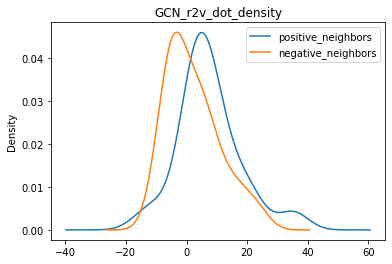

In [26]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [27]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3469.23it/s]


((525, 2), 0.06263405498589592, 0.6765285996055226, 0.3957910698697323)

# GCN ( r2v + fairwalk)

In [28]:
model = "GCN_r2v_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


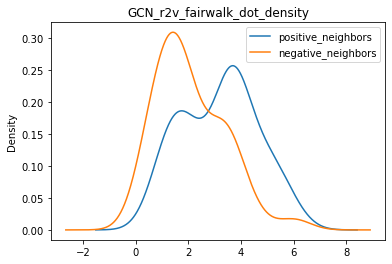

In [29]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [30]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3602.73it/s]


((525, 2), 0.0699319541207918, 0.7264957264957265, 0.429939871713126)

# GAT ( baseline)

In [31]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


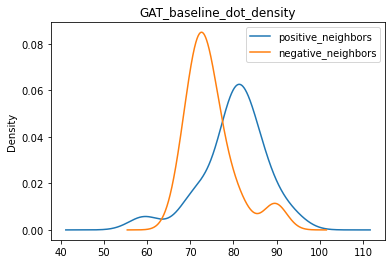

In [32]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [33]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4060.31it/s]


((525, 2), 0.06905455075706575, 0.7633136094674555, 0.4346810939088625)

# GAT ( baseline + fairwalk)

In [34]:
model = "GAT_baseline_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


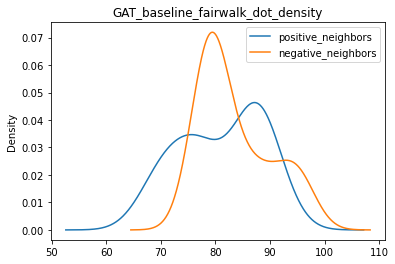

In [35]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [36]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3670.84it/s]


((525, 2), 0.05975296213184102, 0.4095989480604865, 0.381379022943912)

# GAT ( r2v)

In [37]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


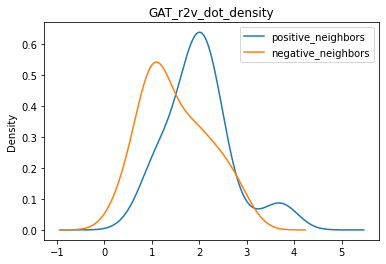

In [38]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [39]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3317.23it/s]


((525, 2), 0.06309997829062056, 0.6893491124260356, 0.39760009417858616)

# GAT ( r2v + fairwalk)

In [40]:
model = "GAT_r2v_fairwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 39


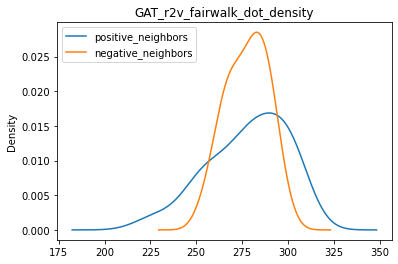

In [41]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [42]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3115.66it/s]


((525, 2), 0.05897623140016408, 0.5410913872452334, 0.38909022384144126)

# plot statistical parity scores

# gini sp scores

word2vec_baseline 0.29057915845324783
word2vec_baseline_fairwalk 0.2966451322695375
word2vec_r2v 0.21927353776091174
word2vec_r2v_fairwalk 0.25536274944495074
GCN_baseline 0.42479922099296136
GCN_baseline_fairwalk 0.4052288102562171
GCN_r2v 0.3957910698697323
GCN_r2v_fairwalk 0.429939871713126
GAT_baseline 0.4346810939088625
GAT_baseline_fairwalk 0.381379022943912
GAT_r2v 0.39760009417858616
GAT_r2v_fairwalk 0.38909022384144126


Text(0.5, 1.0, 'gini statistical parity scores')

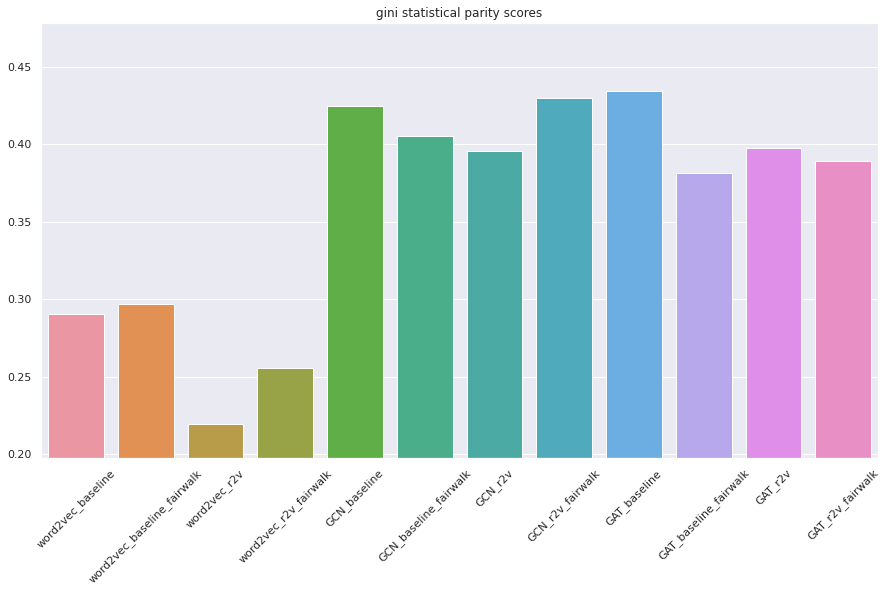

In [43]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

word2vec_baseline 0.03833148596780034
word2vec_baseline_fairwalk 0.04073907199241193
word2vec_r2v 0.027800486921634733
word2vec_r2v_fairwalk 0.03961970556269147
GCN_baseline 0.06848729166655976
GCN_baseline_fairwalk 0.06298851104668694
GCN_r2v 0.06263405498589592
GCN_r2v_fairwalk 0.0699319541207918
GAT_baseline 0.06905455075706575
GAT_baseline_fairwalk 0.05975296213184102
GAT_r2v 0.06309997829062056
GAT_r2v_fairwalk 0.05897623140016408


Text(0.5, 1.0, 'statistical parity scores')

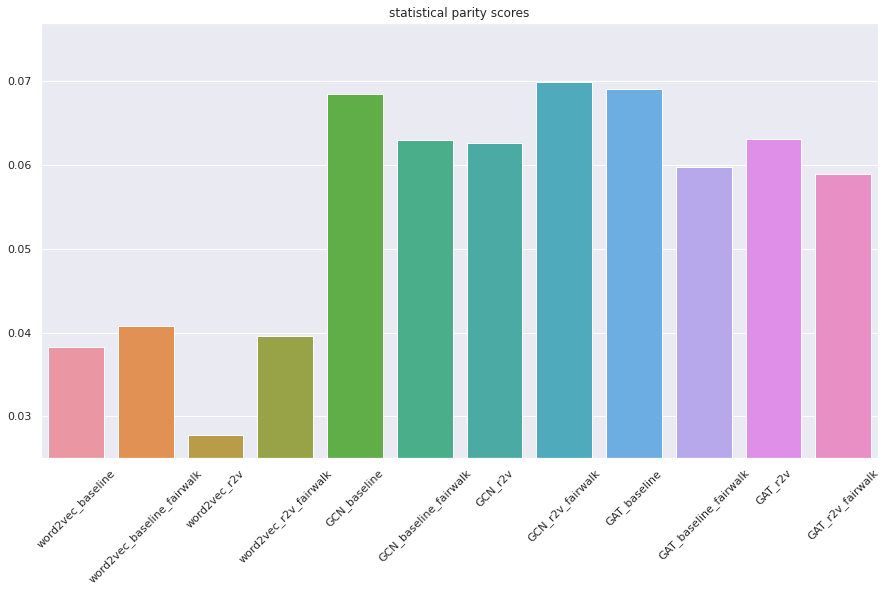

In [44]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

word2vec_baseline 0.873767258382643
word2vec_baseline_fairwalk 0.9388560157790927
word2vec_r2v 0.9066403681788298
word2vec_r2v_fairwalk 0.915844838921762
GCN_baseline 0.8356344510190665
GCN_baseline_fairwalk 0.7232084155161078
GCN_r2v 0.6765285996055226
GCN_r2v_fairwalk 0.7264957264957265
GAT_baseline 0.7633136094674555
GAT_baseline_fairwalk 0.4095989480604865
GAT_r2v 0.6893491124260356
GAT_r2v_fairwalk 0.5410913872452334


Text(0.5, 1.0, 'roc scores')

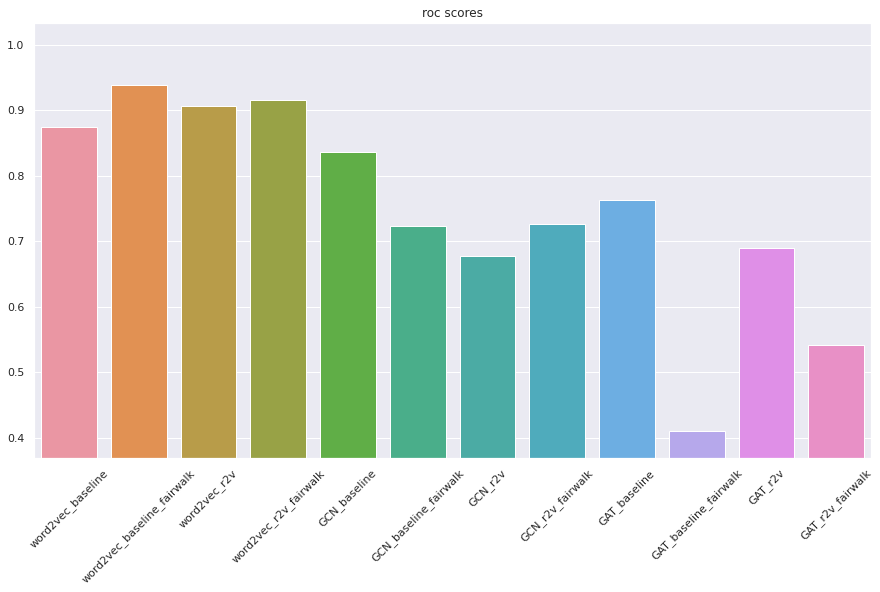

In [45]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [46]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3390.16it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3698.68it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3491.18it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

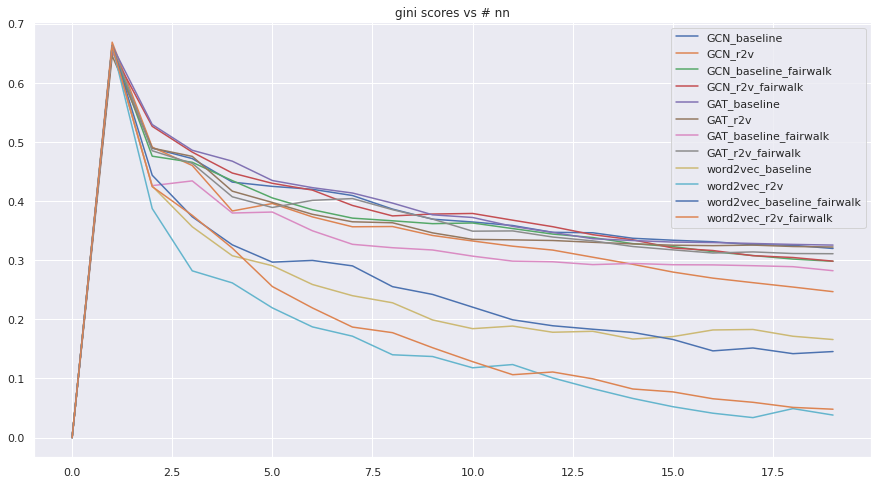

In [47]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

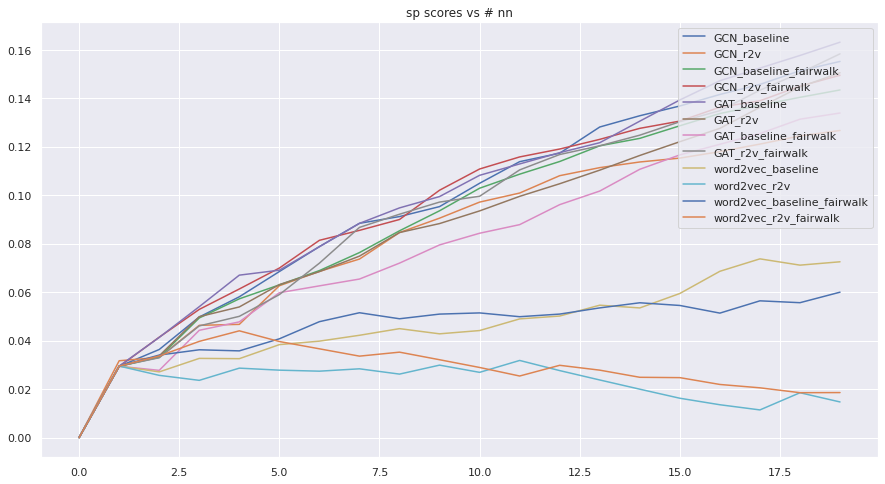

In [48]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [49]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
s

Text(0.5, 1.0, 'roc scores')

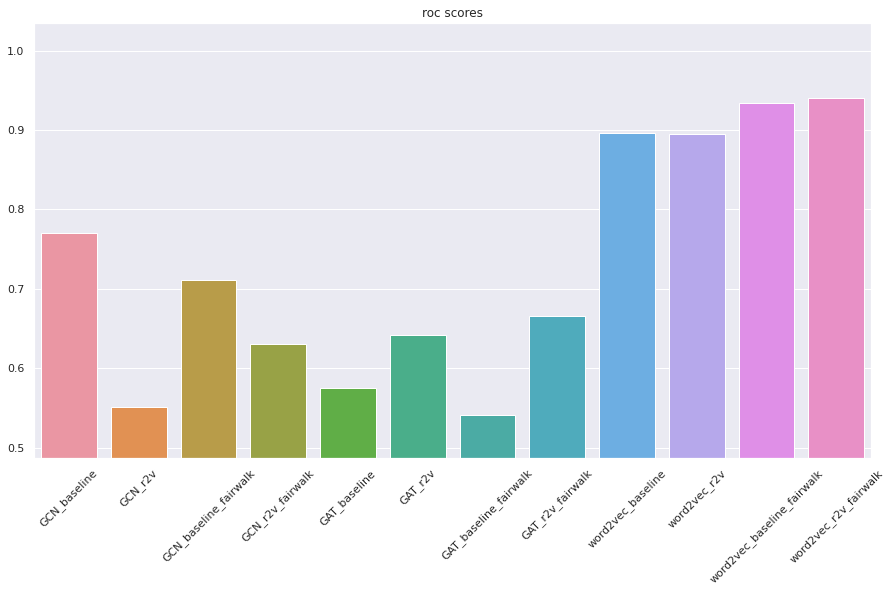

In [50]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3377.06it/s]

GCN_baseline 0.06558040852052477
GCN_r2v 0.06336484149095717
GCN_baseline_fairwalk 0.06470989597749874
GCN_r2v_fairwalk 0.06427613815884431
GAT_baseline 0.06435348570613647
GAT_r2v 0.06596698069162149
GAT_baseline_fairwalk 0.05854601729926588
GAT_r2v_fairwalk 0.059533516355397095
word2vec_baseline 0.0421824735385583
word2vec_r2v 0.03126663475573154
word2vec_baseline_fairwalk 0.0424449655992195
word2vec_r2v_fairwalk 0.030255813242097244


Text(0.5, 1.0, 'statistical parity scores')

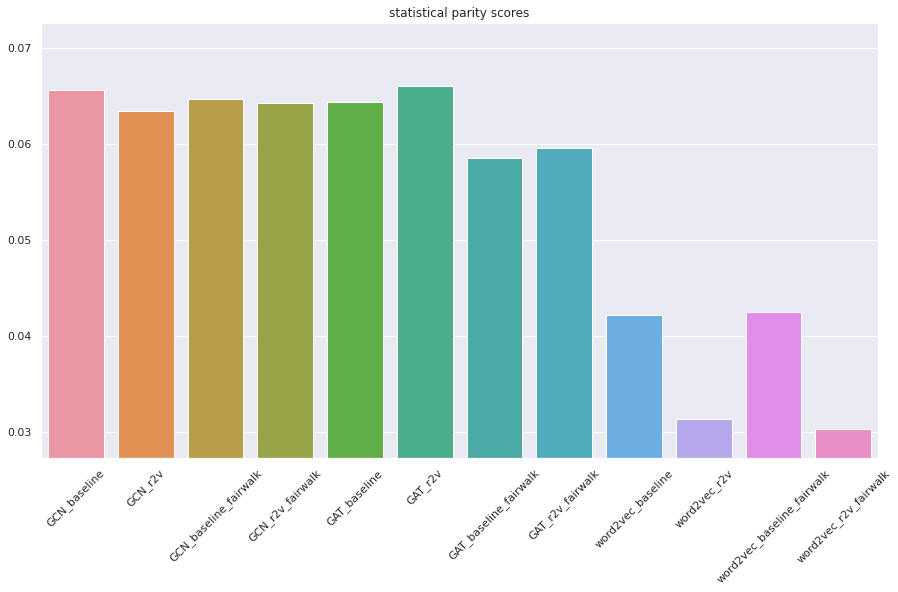

In [51]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.413235853844364
GCN_r2v 0.39807720688718673
GCN_baseline_fairwalk 0.40343788127595437
GCN_r2v_fairwalk 0.4002977850162292
GAT_baseline 0.40615772810097717
GAT_r2v 0.40955567195196363
GAT_baseline_fairwalk 0.38167454346833846
GAT_r2v_fairwalk 0.37997248154026364
word2vec_baseline 0.30377291962287556
word2vec_r2v 0.23876744475774064
word2vec_baseline_fairwalk 0.29502471775920114
word2vec_r2v_fairwalk 0.21770911240554228


Text(0.5, 1.0, 'gini statistical parity scores')

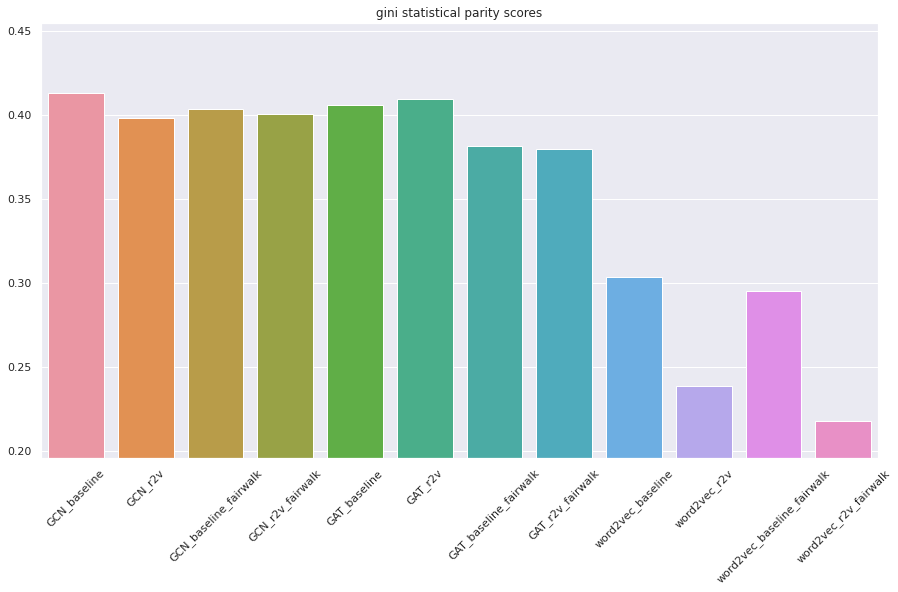

In [52]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [53]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
selected edge_idx size: 40
selected edge_idx size: 41
selected edge_idx size: 39
selected edge_idx size: 39
selected edge_idx size: 42
s

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3852.93it/s]
